# `pytorch` Example

Here we will see how to build neural networks with `pytorch` and why the level of customization that `pytorch` provides is useful.

## Starting with Scikit Learn

First we will motivate this by attempting a new problem with scikit and seeing where it does not provide the flexibility we need to continue.

Scikit is extremely simple and easy to use, but it does not provide interfaces that allow for a high level of customization of our neural networks.

For this, we need to use more powerful deep learning tools. There are many deep learning tools available in Python. We will look at `pytorch` here.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd

from mlp_visualization import print_ascii_mlp
from mlp_visualization import display_mlp

maximum_iterations = 1

### Load Data

We start by loading a dataset which catalogues personality and aptitude test scores for individuals who chose different careers.

In [2]:
career_data_path = "./datasets/career/Data_final.csv"
career_df = pd.read_csv(career_data_path)

career_df.head()

,O_score,C_score,E_score,A_score,N_score,Numerical Aptitude,Spatial Aptitude,Perceptual Aptitude,Abstract Reasoning,Verbal Reasoning,Career
0,5.45,8.67,3.45,5.34,4.23,9.23,4.56,6.78,7.89,6.12,Accountant
1,8.78,5.67,4.56,6.45,4.23,5.12,8.45,7.89,6.34,6.01,Graphic Designer
2,6.12,6.78,9.34,7.56,5.01,6.23,4.23,6.45,6.67,8.45,Salesperson
3,9.12,8.78,4.23,5.67,4.56,7.89,5.34,6.45,9.34,7.67,Research Scientist
4,6.45,7.56,5.67,9.12,4.23,5.34,4.01,6.23,5.78,8.67,Teacher


Before we do any machine learning, let us see how many rows there are and how many unique labels there are. There are many potential careers, and if we plan to predict someone's career from their aptitude test scores, we will need many examples of each career. We need at least enough so we can fit a model to some examples of each career and then test it on some untrained examples.

In [3]:
target_column = "Career"

features_list = career_df.columns.to_list()
features_list.remove(target_column)

number_of_rows = len(career_df)
number_of_features = len(features_list)

print(f"The data has {number_of_rows} rows.\n")

print(f"The data has {number_of_features} features:")
for feature in features_list:
    print(f"    - {feature}")
print()

label_strings = career_df[target_column].to_list()


def check_for_duplicates(input_list):
    """Checks a list for duplicates"""
    input_list_no_duplicates = set(input_list)
    has_duplicates = len(input_list) != len(input_list_no_duplicates)
    return has_duplicates, input_list_no_duplicates


repeated_labels, unique_label_strings = check_for_duplicates(label_strings)

if repeated_labels:
    print("The data has repeated labels.")
else:
    print("The data does not have repeated labels.")
print()

print(f"The data has {len(unique_label_strings)} unique labels:")
for unique_label in unique_label_strings:
    print(f"    - {unique_label}")
print()

The data has 105 rows.

The data has 10 features:
    - O_score
    - C_score
    - E_score
    - A_score
    - N_score
    - Numerical Aptitude
    - Spatial Aptitude
    - Perceptual Aptitude
    - Abstract Reasoning
    - Verbal Reasoning

The data has repeated labels.

The data has 104 unique labels:
    - Urban Planner
    - Social Media Manager
    - Event Planner
    - Diplomat
    - Forestry Technician
    - Administrative Officer
    - Real Estate Agent
    - Foreign Service Officer
    - Dental Hygienist
    - IT Support Specialist
    - Biomedical Researcher
    - Web Developer
    - Airline Pilot
    - Marriage Counselor
    - Physician
    - Architect
    - Marketing Analyst
    - Occupational Therapist
    - Teacher
    - Lawyer
    - Game Developer
    - Mechanical Engineer
    - Industrial Engineer
    - Biologist
    - Investment Banker
    - Graphic Designer
    - Social Worker
    - Accountant
    - Research Scientist
    - Nurse
    - Environmental Scientist
    - T

We see that the data has 105 rows and 104 unique labels. Unfortunately, that means we barely have any careers with multiple examples. We cannot use this dataset to perform prediction.

However, that doesn't mean that we cannot use machine learning techniques to extract insights from this dataset! Here we will attempt to use an autoencoder to reduce our dataset to a few meaningful features, without needing labels.

This is like a nonlinear version of principal component analysis.

### Build an Autoencoder (Attempt 1)

Here we attempt to build an autoencoder with scikit learn. An autoencoder is wide at the edges and narrow in the middle. The end of the autoencoder reconstructs the original data from the narrow layers. This forces the neural network to reconstruct the data from a limited amount of information in the narrow center. This ensures that the narrow center captures as much information about the underlying data as possible.

In [4]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

features_df = career_df[features_list]
features_array_x = features_df.to_numpy()

number_of_inputs = number_of_features
number_of_outputs = number_of_features
number_of_intermediate = 5
number_of_latent_variables = 1

autoencoder_structure = (
    number_of_inputs,
    number_of_inputs,
    number_of_intermediate,
    number_of_intermediate,
    number_of_latent_variables,
    number_of_intermediate,
    number_of_intermediate,
    number_of_inputs,
    number_of_inputs,
)
scaler = StandardScaler()
features_array_x_scaled = scaler.fit_transform(features_array_x)
autoencoder_mlp = MLPRegressor(
    hidden_layer_sizes=autoencoder_structure,
    max_iter=maximum_iterations,
    tol=1e-7,
    n_iter_no_change=10,
    activation="relu",
    solver="adam",
    random_state=123,
)

### Fit the Autoencoder

In [5]:
autoencoder_mlp.fit(features_array_x_scaled, features_array_x_scaled)

/workspaces/fall-2024-class-03/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(10, 10, 5, 5, 1, 5, 5, 10, 10), max_iter=1,
             random_state=123, tol=1e-07)

### Test the Autoencoder

In [6]:
predicted_features = autoencoder_mlp.predict(features_array_x_scaled)

mse = mean_squared_error(features_array_x_scaled, predicted_features)

print(
    f"The autoencoder reconstructs its features from {number_of_latent_variables} latent variable with MSE = {mse}"
)

The autoencoder reconstructs its features from 1 latent variable with MSE = 1.1982198708617184


We see that the autoencoder is able to reconstruct its features with very little error. This is encouraging.

Now we can visualize the autoencoder to see how well it has learned.

Layer   0:     .  .  .  .  .  .  .  .  .  .   
Layer   1:     .  .  .  .  .  .  .  .  .  .   
Layer   2:     .  .  .  .  .  .  .  .  .  .   
Layer   3:            .  .  .  .  .           
Layer   4:            .  .  .  .  .           
Layer   5:                  .                 
Layer   6:            .  .  .  .  .           
Layer   7:            .  .  .  .  .           
Layer   8:     .  .  .  .  .  .  .  .  .  .   
Layer   9:     .  .  .  .  .  .  .  .  .  .   
Layer  10:     .  .  .  .  .  .  .  .  .  .   


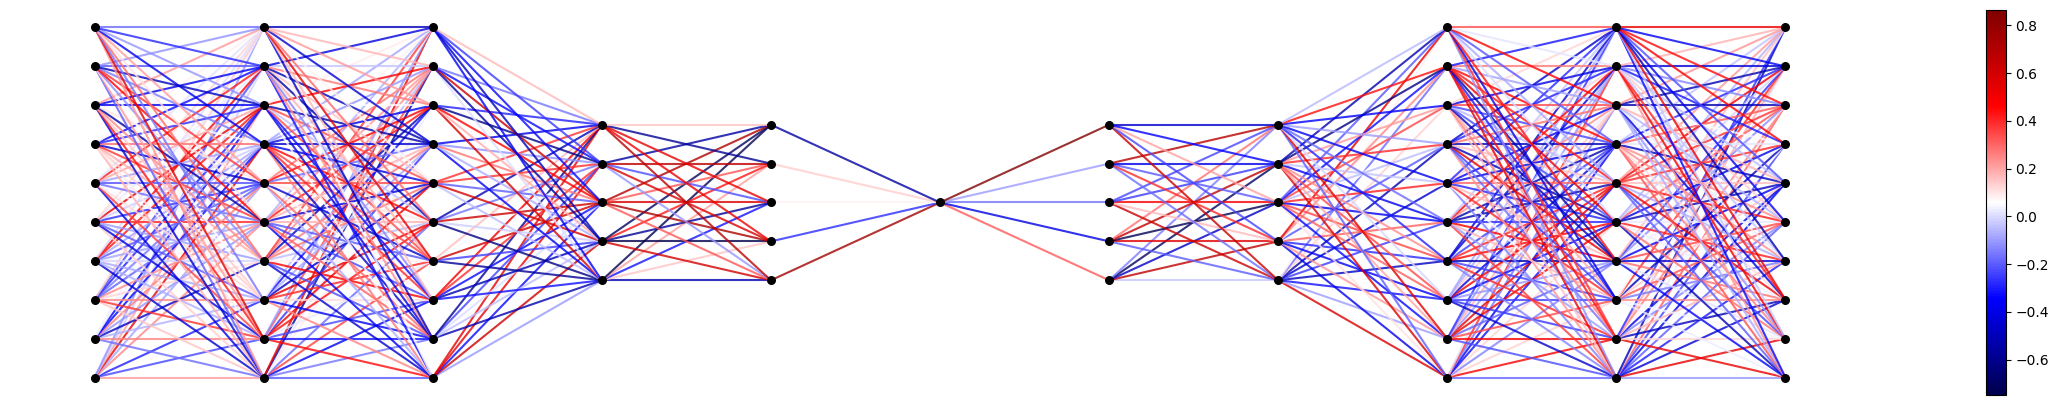

In [7]:
print_ascii_mlp(autoencoder_mlp)

_ = display_mlp(
    autoencoder_mlp,
    linewidth=1.5,
    neuron_alpha=1,
    neuron_color="black",
    line_alpha=0.8,
    figure_width=30,
    figure_height=5,
    neuron_size=30,
    colormap_name="seismic",
)

This is not bad. It seems that the autoencoder has formed strong neural pathways which can reconstruct the original data from the narrow latent features.

However, we now want to access the value of the network in the narrow middle layer. Unfortunately, scikit does not provide an easy way for us to do this. Let's take a look at how we can do this with `pytorch` instead.

## Building an Autoencoder with Pytorch

Using pytorch, we can easily built custom neural network architectures. Pytorch handles all the details of optimization for us, just like scikit, but allows a great deal of customization.

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

### Define the Autoencoder

In pytorch, we define a neural network as a class and use pytorch's built in constructs to define the layers.

In [9]:
# Define a simple autoencoder class
class AutoencoderNetwork(nn.Module):
    def __init__(self, number_of_inputs, width_latent, width_intermediate):
        super(AutoencoderNetwork, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(number_of_inputs, number_of_inputs),
            nn.ReLU(),
            nn.Linear(number_of_inputs, number_of_inputs),
            nn.ReLU(),
            nn.Linear(number_of_inputs, width_intermediate),
            nn.ReLU(),
            nn.Linear(width_intermediate, width_intermediate),
            nn.ReLU(),
            nn.Linear(width_intermediate, width_latent),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(width_latent, width_intermediate),
            nn.ReLU(),
            nn.Linear(width_intermediate, width_intermediate),
            nn.ReLU(),
            nn.Linear(width_intermediate, number_of_inputs),
            nn.ReLU(),
            nn.Linear(number_of_inputs, number_of_inputs),
            nn.ReLU(),
            nn.Linear(number_of_inputs, number_of_inputs),
        )

        # Weight initialization
        #
        # In this case, random initialization with non-zero mean was key to
        # getting convergence.
        for layer in self.encoder.children():
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0.1, std=0.1)

        for layer in self.decoder.children():
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0.1, std=0.1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Load the Career Dataset

This step is exactly the same as it was before. We can even use the scikit normalization processing if we want to stay consistent. It is common to use tools from both scikit and pytorch in the same project.

In [10]:
# Load the career dataset
career_data_path = "./datasets/career/Data_final.csv"
career_df = pd.read_csv(career_data_path)

# Preprocess the dataset
target_column = "Career"
features_list = career_df.columns.to_list()
features_list.remove(target_column)
number_of_features = len(features_list)
features_df = career_df[features_list]
features_array_x = features_df.to_numpy()

# Normalize the features
scaler = StandardScaler()
features_array_x_scaled = scaler.fit_transform(features_array_x)

# **New step**: convert the features to a torch tensor
input_tensor = torch.tensor(features_array_x_scaled, dtype=torch.float32)

### Set the Parameters of the Network

Here we set the parameters of the network, define its loss function, and its optimizer.

In [11]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set parameters
number_of_inputs = number_of_features
width_latent = 1
width_intermediate = 5
learning_rate = 0.005

# Initialize the network
model = AutoencoderNetwork(
    number_of_inputs, width_latent, width_intermediate
).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Train the Network

Pytorch requires we write our own training loop. This is easier to understand with some background in deep learning. We will assume this background was covered in prior classes (if not, we can review next class). For now, it is enough to know this is the equivalent of scikit's `.fit()` function.

In [12]:
# Train the neural network
number_of_epochs = 5000

for epoch in range(number_of_epochs):
    output = model(input_tensor)
    loss = criterion(output, input_tensor)

    # Zero gradients, backward pass, and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{number_of_epochs}], Loss: {loss.item():.4f}")

print("Finished training!")

Epoch [100/5000], Loss: 0.7833
Epoch [200/5000], Loss: 0.5848
Epoch [300/5000], Loss: 0.5161
Epoch [400/5000], Loss: 0.4355
Epoch [500/5000], Loss: 0.3857
Epoch [600/5000], Loss: 0.3661
Epoch [700/5000], Loss: 0.3555
Epoch [800/5000], Loss: 0.3388
Epoch [900/5000], Loss: 0.3335
Epoch [1000/5000], Loss: 0.3227
Epoch [1100/5000], Loss: 0.3186
Epoch [1200/5000], Loss: 0.3111
Epoch [1300/5000], Loss: 0.3163
Epoch [1400/5000], Loss: 0.3039
Epoch [1500/5000], Loss: 0.2973
Epoch [1600/5000], Loss: 0.2939
Epoch [1700/5000], Loss: 0.2916
Epoch [1800/5000], Loss: 0.2908
Epoch [1900/5000], Loss: 0.2966
Epoch [2000/5000], Loss: 0.3015
Epoch [2100/5000], Loss: 0.2802
Epoch [2200/5000], Loss: 0.2757
Epoch [2300/5000], Loss: 0.2991
Epoch [2400/5000], Loss: 0.2750
Epoch [2500/5000], Loss: 0.2687
Epoch [2600/5000], Loss: 0.2732
Epoch [2700/5000], Loss: 0.2644
Epoch [2800/5000], Loss: 0.2655
Epoch [2900/5000], Loss: 0.2608
Epoch [3000/5000], Loss: 0.2576
Epoch [3100/5000], Loss: 0.2559
Epoch [3200/5000]

## Put the Encoder to Use!

The encoder half of the network can accept features as input and tell us where they are in the embedding space. Embedding spaces can help us uncover and visualize meaning in our data even if we do not have labels.

Here we generate embeddings for all of our samples. We also compute the minimum, maximum, and midpoints of the embedding space.


In [13]:
embeddings = model.encoder(input_tensor)
embeddings_array = embeddings.detach().numpy()

career_df["Embedding"] = embeddings_array

min_embedding = embeddings_array.min()
max_embedding = embeddings_array.max()
midpoint = (max_embedding - min_embedding) / 2

A quick histogram shows us that individuals tend to cluster in one of two groups.

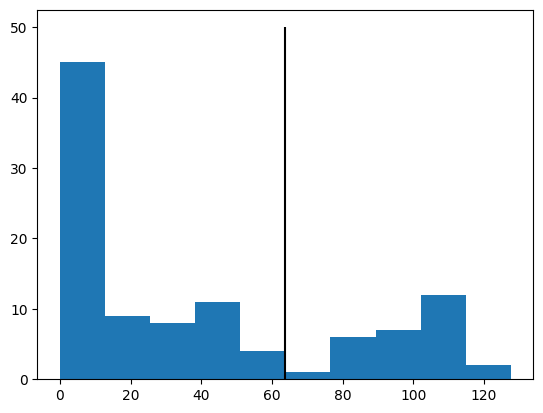

In [14]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
plt.hist(career_df["Embedding"])
plt.vlines(x=midpoint, ymin=0, ymax=50, color="k")

Let's center the embedding.

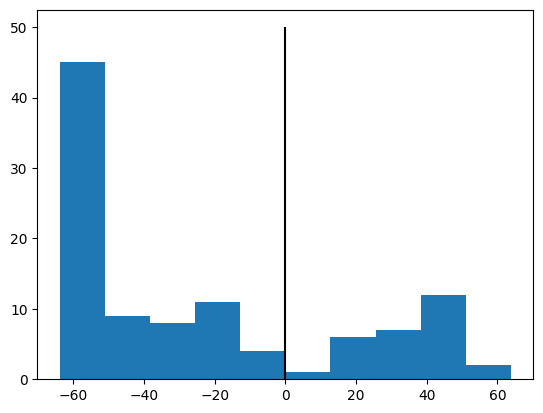

In [15]:
career_df["Embedding"] = career_df["Embedding"] - midpoint

plt.figure()
plt.hist(career_df["Embedding"])
plt.vlines(x=0, ymin=0, ymax=50, color="k")

Now we can use scikit to cluster in embedding space. This will allow us to group our samples depending on which of the natural collections above they fall into.

In [16]:
from sklearn.cluster import KMeans

n_clusters = 2  # Number of clusters
k_means = KMeans(n_clusters=n_clusters, random_state=2)
k_means.fit(embeddings_array.reshape(-1, 1))

# Get cluster centers and labels
cluster_centers = k_means.cluster_centers_
labels = k_means.labels_
centroids = k_means.cluster_centers_

print(centroids)

career_df["Cluster"] = labels

career_df.head()

[[99.57561 ]
 [16.545189]]


,O_score,C_score,E_score,A_score,N_score,Numerical Aptitude,Spatial Aptitude,Perceptual Aptitude,Abstract Reasoning,Verbal Reasoning,Career,Embedding,Cluster
0,5.45,8.67,3.45,5.34,4.23,9.23,4.56,6.78,7.89,6.12,Accountant,22.490517,0
1,8.78,5.67,4.56,6.45,4.23,5.12,8.45,7.89,6.34,6.01,Graphic Designer,41.099945,0
2,6.12,6.78,9.34,7.56,5.01,6.23,4.23,6.45,6.67,8.45,Salesperson,-53.601631,1
3,9.12,8.78,4.23,5.67,4.56,7.89,5.34,6.45,9.34,7.67,Research Scientist,24.774857,0
4,6.45,7.56,5.67,9.12,4.23,5.34,4.01,6.23,5.78,8.67,Teacher,-58.027550,1


We can use seaborn to quickly generate color coded histograms.

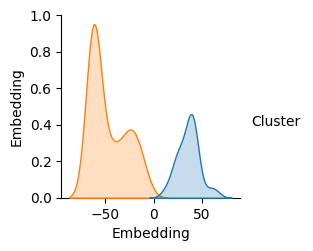

In [17]:
import seaborn as sns

pairplot_list = ["Embedding", "Cluster"]
sns.pairplot(career_df[pairplot_list], hue="Cluster")

In [18]:
# This code generates the full pair plot
# pairplot_list = features_list + ["Embedding", "Cluster"]
# sns.pairplot(career_df[pairplot_list], hue="Cluster")

What could these clusters mean?

Let's provide ourselves the ability to look at their magnitude and direction separately by adding a column for the absolute value of the embedding.

Then let's find all the careers associated with each side of the embedding and store them in a dictionary with their magnitude.

In [19]:
career_df["Absolute Embedding"] = np.abs(career_df["Embedding"])

words_cluster0 = career_df[career_df["Cluster"] == 0][
    ["Career", "Absolute Embedding"]
]
words_cluster1 = career_df[career_df["Cluster"] == 1][
    ["Career", "Absolute Embedding"]
]

dict_cluster0 = words_cluster0.set_index("Career").to_dict()[
    "Absolute Embedding"
]
dict_cluster1 = words_cluster1.set_index("Career").to_dict()[
    "Absolute Embedding"
]

With the clusters separated into dictionaries, we can generate a wordcloud showing the magnitude of each word in embedding space, and showing which side of the embedding each falls on.

(np.float64(-0.5), np.float64(999.5), np.float64(999.5), np.float64(-0.5))

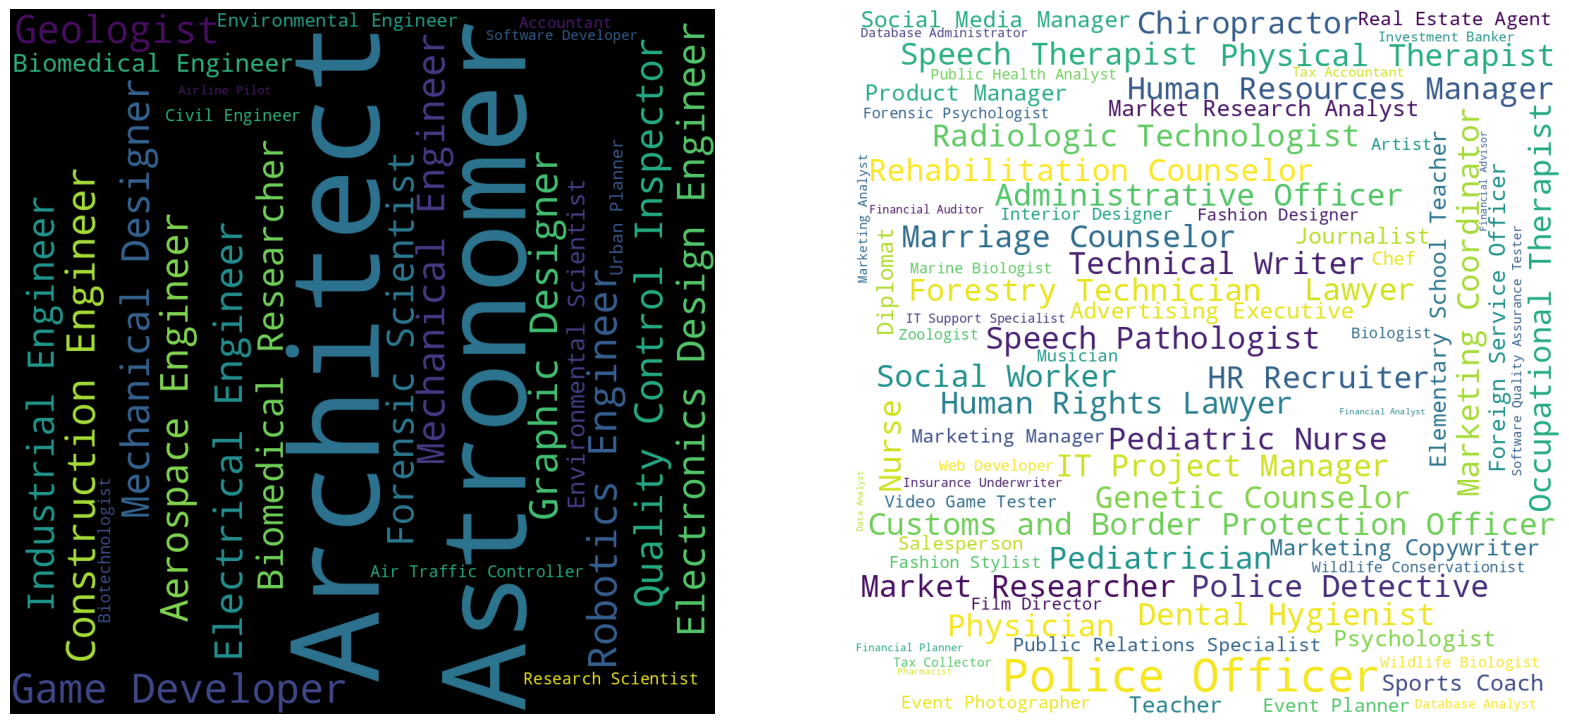

In [20]:
from wordcloud import WordCloud

text_cluster0 = ", ".join(words_cluster0)
text_cluster1 = ", ".join(words_cluster1)
wordcloud_cluster0 = WordCloud(
    width=1000, height=1000, background_color="black"
).generate_from_frequencies(dict_cluster0)
wordcloud_cluster1 = WordCloud(
    width=1000, height=1000, background_color="white"
).generate_from_frequencies(dict_cluster1)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(wordcloud_cluster0)
axes[1].imshow(wordcloud_cluster1)
axes[0].axis("off")
axes[1].axis("off")

This looks a lot like we have clustered by left brain and right brain dominant professions, without having had any labels about left vs. right brain thinking, or even any notion of what that is!

Let's sort by the embedding and bar plot the embedding along with all the careers.

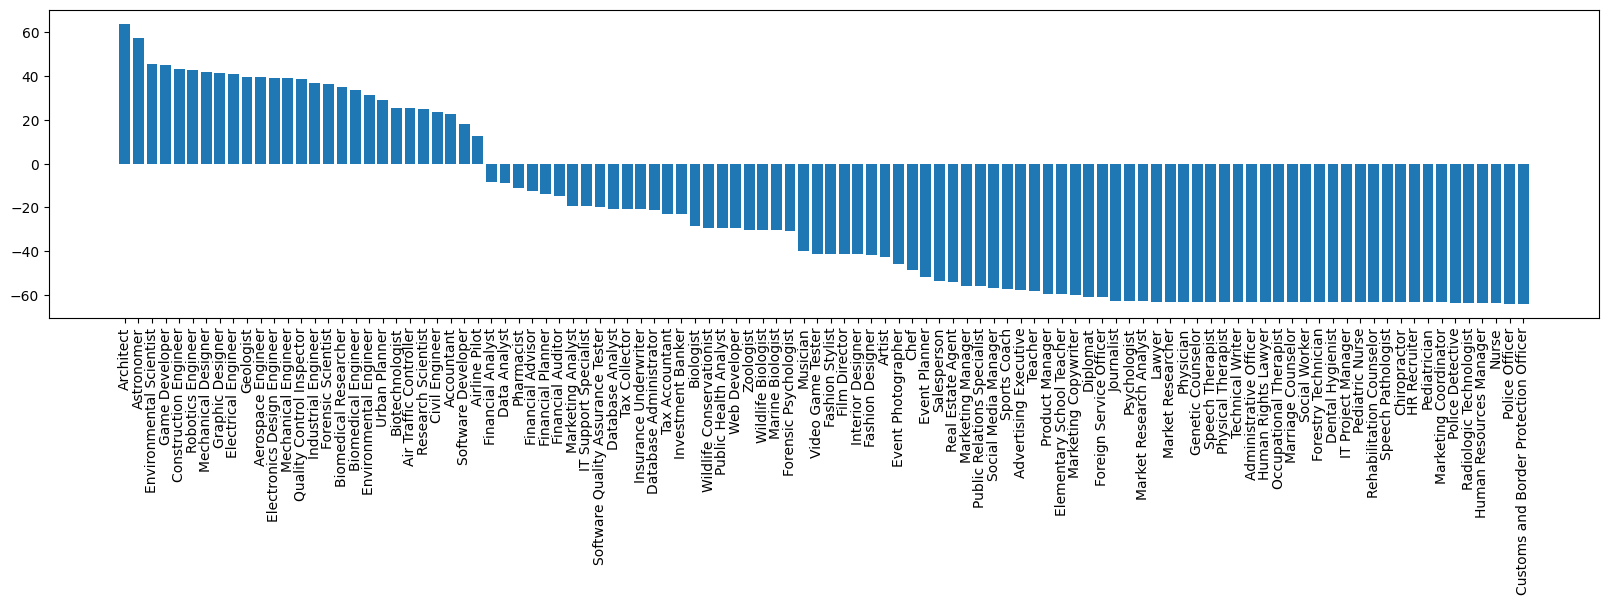

In [21]:
career_df_sorted = career_df.sort_values(by="Embedding", ascending=False)

plt.figure(figsize=(20, 4))
plt.bar(x=career_df_sorted["Career"], height=career_df_sorted["Embedding"])
plt.xticks(rotation="vertical")
plt.show()

## Put the Decoder to Good Use

We can also use the decoder to generate data from the distribution of features we trained from. That means we can generate imaginary job candidates with test scores that would make them appear qualified for left brain or right brain jobs!

In [22]:
# Pick some latent space values
# Low numbers = left brain (cluster 1)
# High numbers = right brain (cluster 2)
synthetic_personality_embeddings = np.array([0, 50, 100])

synthetic_personality_embeddings_tensor = torch.tensor(
    synthetic_personality_embeddings.reshape(-1, 1), dtype=torch.float32
)
synthetic_job_profiles = model.decoder(synthetic_personality_embeddings_tensor)

synthetic_job_profiles_array = synthetic_job_profiles.detach().numpy()

synthetic_job_profiles_array_rescaled = scaler.inverse_transform(
    synthetic_job_profiles_array
)

synthetic_careers_df = pd.DataFrame(
    data=synthetic_job_profiles_array_rescaled, columns=features_list
)

synthetic_careers_df.head()

,O_score,C_score,E_score,A_score,N_score,Numerical Aptitude,Spatial Aptitude,Perceptual Aptitude,Abstract Reasoning,Verbal Reasoning
0,2.477682,8.265613,7.546597,8.824411,6.469056,4.466263,3.281642,4.199898,4.609544,5.970671
1,6.394199,8.719065,4.328481,6.407780,4.915240,8.723385,3.282643,3.782973,4.123805,6.820311
2,7.686379,7.699418,4.287064,5.276731,4.542472,7.933194,7.107952,6.440860,7.866934,5.494740
